<img src="NotebookAddons/banner_notebook.jpg" width="100%" />

# InSAR Time Series Analysis dengan MintPy dari Dataset HyP3 

**Penulis:** Alex Lewandowski; University of Alaska Fairbanks
**Dimodifikasi oleh:** Gunawan Wisnu Wardhana; Institut Teknologi Sepuluh Nopember

Berdasarkan notebook yang ditulis oleh Eric Fielding, David Bekaert, Heresh Fattahi and Yunjun Zhang, yang menggunakan dataset ARIA. [LosAngeles_time_series](https://github.com/ASFOpenSARlab/opensarlab-notebooks/blob/master/SAR_Training/English/Hazards/LosAngeles_time_series.ipynb)


## Deformasi Permukaan dengan data time series InSAR
Berikut adalah pengolahan data time series dari data stack ASF Hyp3 InSAR yang telah dipersiapkan sebelumnya.
Proses ini selain menghasilkan nilai displacement rate atau velocity deformasi juga memungkinkan kita untuk mengevaluasi kualitas dari stack inversion, temporal coherence dan velocity error.


In [1]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

URLWidget()

In [2]:
from IPython.display import Markdown
from IPython.display import display

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX
if env[0] == '':
    env[0] = 'Python 3 (base)'
if env[0] != '/home/jovyan/.local/envs/insar_analysis':
    display(Markdown(f'<text style=color:red><strong>WARNING:</strong></text>'))
    display(Markdown(f'<text style=color:red>This notebook should be run using the "insar_analysis" conda environment.</text>'))
    display(Markdown(f'<text style=color:red>It is currently using the "{env[0].split("/")[-1]}" environment.</text>'))
    display(Markdown(f'<text style=color:red>Select "insar_analysis" from the "Change Kernel" submenu of the "Kernel" menu.</text>'))
    display(Markdown(f'<text style=color:red>If the "insar_analysis" environment is not present, use <a href="{notebookUrl.split("/user")[0]}/user/{user[0]}/notebooks/conda_environments/Create_OSL_Conda_Environments.ipynb"> Create_OSL_Conda_Environments.ipynb </a> to create it.</text>'))
    display(Markdown(f'<text style=color:red>Note that you must restart your server after creating a new environment before it is usable by notebooks.</text>'))

# 1: Pengaturan Notebook Awal

**Import package yang diperlukan**

In [3]:
import contextlib
import csv
from datetime import datetime
from getpass import getpass
import h5py
import os
from pathlib import Path
import re
import rioxarray as rxr
from tqdm.notebook import tqdm
from typing import Union
import urllib
import xarray as xr
import zipfile

from ipyfilechooser import FileChooser

import numpy as np

# diff behavior based on mintpy <= 1.4.1 or > 1.4.1
from importlib.metadata import version as getVersion
from packaging import version as compareVersion
isLatest = compareVersion.parse(getVersion('mintpy')) > compareVersion.parse('1.4.1')

# MintPy ver beyond 1.4.1
if isLatest:
    from mintpy.cli import view, tsview, plot_network, plot_transection, plot_coherence_matrix
# MintPy <= 1.4.1 (old)
else:
    import mintpy.view as view
    import mintpy.tsview as tsview
    import mintpy.plot_network as plot_network
    import mintpy.plot_transection as plot_transection
    import mintpy.plot_coherence_matrix as plot_coherence_matrix

import mintpy.plot_coherence_matrix
from osgeo import gdal, osr

import rasterio
from rasterio.transform import from_origin

import mintpy.objects.insar_vs_gps
import mintpy.utils

import opensarlab_lib as asfn

**Pilih directory/folder kerja**
- Klik tombol `Select` 
- Arahkan ke folder kerja
- Klik tombol `Select`
- Pastikan jika alamat folder yang muncul sesuai yang dipilih (text hijau)
- Klik tombol `Change` jika perlu mengganti alamat

In [4]:
path = Path.cwd()
fc = FileChooser(path)
display(fc)

FileChooser(path='/home/jovyan/Labs/Thesis', filename='', title='', show_hidden=False, select_desc='Select', c…

**Atur alamat untuk penyimpanan dataset InSAR dan folder hasil analisis**

In [5]:
# define the work directory (folder kerja dimana notebook ini disimpan)
work_path = Path(fc.selected_path)
print(f"Work directory: {work_path}")

# alamat time series insar data dari process sebelumnya (hyp3, isce, dsb)
insar_path = work_path/'hyp3_look_10x2_23_ifgram'
print(f"Work directory: {insar_path}")

# nama project
proj_name = input("Enter a project name: ")

# alamat untuk menyimpan hasil MintPy time-series analysis
mint_path = work_path/'hyp3_look_10x2_23_process'
mint_path.mkdir(exist_ok=True)
print(f"MintPy directory: {mint_path}")

# alamat untuk menyimpan hasil plot 
plot_path = mint_path/"plots"
plot_path.mkdir(exist_ok=True)

Work directory: /home/jovyan/Labs/Thesis
Work directory: /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_ifgram


Enter a project name:  mining_defo


MintPy directory: /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_process


# 2. Tambahkan Climate Data Store (CDS) UID & API Key

### Proses ini cukup dijalankan sekali dan bisa dilewati jika CDS config sudah diupdate

- Untuk menjalankan tahap `correct_troposphere` di MintPy membutuhkan data atmospheric pressure dari CDS untuk itu perlu CDS API key
- Jika belum memiliki CDS API key:
    - Buat akun di [CDS](https://cds.climate.copernicus.eu/cdsapp#!/home)
    - Buka [Datasets page](https://cds.climate.copernicus.eu/cdsapp#!/search?type=dataset)
    - Cari "ERA5"
    - Pilih salah satu dataset ERA5 yang muncul di pencarian
    - Pilih tab `Download data`
    - Scroll hingga bagian bawah halaman
    - Accept the `Terms of use`
    - Masuk ke halaman profile, ada di nama akun di kanan atas
    - `UID` dan `API Key` akan muncul di sini
- Run the following 2 code cells to update the pyaps config from this notebook **OR** open an OpenSARlab terminal and complete the following steps:
    - Use vim or another text editor to open the `~/.cdsapirc` config file
        - Add the CDS url to the first line of the config and your CDS `UID` and CDS`API Key` to the 2nd line of the config
            - This should be formatted like:
                - url: https://cds.climate.copernicus.eu/api/v2\
                - your_UID: your_API_Key
        - Save the config and exit the text editor

**If you do not add your CDS credentials to `~/.cdsapirc`, the `correct_troposphere` step will fail**

In [6]:
pyaps_cfg = Path("/home/jovyan/.cdsapirc")
try:
    with open(pyaps_cfg, 'r') as f:
        lines = f.readlines()
        if len(lines) == 2 and 'url' in lines[0]:
            print("There was a CDS UID and API Key found in the pyaps3 config: ~/.cdsapirc")
            print("Would you like to update them?")
            update_cds_cfg = asfn.select_parameter(["Do not update CDS UID and API Key", 
                                                    "Update CDS UID and API Key"])
            display(update_cds_cfg)
        else:
            update_cds_cfg = None
except FileNotFoundError:
    update_cds_cfg = None

There was a CDS UID and API Key found in the pyaps3 config: ~/.cdsapirc
Would you like to update them?


RadioButtons(layout=Layout(min_width='800px'), options=('Do not update CDS UID and API Key', 'Update CDS UID a…

In [7]:
if not update_cds_cfg or "Update" in update_cds_cfg.value:
    with open(pyaps_cfg, 'w') as f:
            uid = input("Enter your CDS UID")
            key = getpass("Enter your CDS API Key")
            lines = ['', '']
            lines[0] = f"url: https://cds.climate.copernicus.eu/api/v2\n"
            lines[1] = f"key: {uid}:{key}\n"
            f.seek(0)
            f.writelines(lines)
            f.truncate()

# 3. Overview proses di smallbaselineApp.py

Aplikasi ini menyediakan _workflow_ untuk inversion stack dari unwrapped interferogram serta menerapkan beberapa koreksi untuk mendapatkan _displacement_ secara time series.
Workflow tersebut dibagi menjadi 2 bagian utama:

* koreksi unwrapping error dan inversion raw data fase (simbol elips warna biru)
* koreksi noise yang berasal dari berbagai sumber yang berkontribusi terhadap noise (simbol elips warna hijau)

Beberapa tahap merupakan pilihan, secara default di-off kan (simbol outline putus-putus). Konfigurasi parameter untuk tiap tahap diinisiasi dengan nilai default di text file yang dapat diatur: [smallbaselineApp.cfg](https://github.com/insarlab/MintPy/blob/master/mintpy/defaults/smallbaselineApp.cfg). Untuk tahpaan lengkap silakan dilihat di [MintPy repository](https://github.com/insarlab/MintPy).


<p align="left">
  <img width="600" src="https://opensarlab-docs.asf.alaska.edu/opensarlab-notebook-assets/notebook_images/MintPyWorkflow.jpg">
</p>     
<p style="text-align: center;">
    (Figure from Yunjun et al., 2019)
</p>

## 3.1. Tahap Processing di smallbaselineApp.py

The MintPy **smallbaselineApp.py** application provides a workflow to invert a stack of unwrapped interferograms and apply different (often optional) corrections to obtain ground displacement timeseries. A detailed overview of the options can be retrieved by involking the help option:

In [8]:
!smallbaselineApp.py --help

usage: smallbaselineApp.py [-h] [--dir WORKDIR] [-g] [-H] [-v] [--plot]
                           [--start STEP] [--end STEP] [--dostep STEP]
                           [customTemplateFile]

Routine Time Series Analysis for Small Baseline InSAR Stack

positional arguments:
  customTemplateFile    custom template with option settings.
                        ignored if the default smallbaselineApp.cfg is input.

optional arguments:
  -h, --help            show this help message and exit
  --dir WORKDIR, --work-dir WORKDIR
                        work directory, (default: ./).
  -g                    generate default template (if it does not exist) and exit.
  -H                    print the default template file and exit.
  -v, --version         print software version and exit
  --plot                plot results [only] without running smallbaselineApp.

steps processing (start/end/dostep):
  Command line options for steps processing with names are chosen from the following list:
  
  

## 3.2. Configuring processing parameters

The processing parameters for the **smallbaselineApp.py** are controlled through a configuration file. If no file is provided the default [smallbaselineApp.cfg](https://github.com/insarlab/MintPy/blob/master/mintpy/defaults/smallbaselineApp.cfg) configuration is used. We will create a custom config file with modified configuration parameters for this time-series analysis. Any options added to the custom config will override options set in the default config.

In [9]:
config = f'''# vim: set filetype=cfg:
mintpy.load.processor        = hyp3
##---------interferogram stack datasets:
mintpy.load.unwFile          = {insar_path}/*/*unw_phase_clip.tif
mintpy.load.corFile          = {insar_path}/*/*corr_clip.tif
##---------geometry datasets:
mintpy.load.demFile          = {insar_path}/*/*dem_clip.tif
mintpy.load.incAngleFile     = {insar_path}/*/*lv_theta_clip.tif
mintpy.load.azAngleFile      = {insar_path}/*/*lv_phi_clip.tif
mintpy.load.waterMaskFile    = {insar_path}/*/*water_mask_clip.tif

########## 2. modify_network
mintpy.network.coherenceBased  = yes  #[yes / no], auto for no, exclude interferograms with coherence < minCoherence
mintpy.network.minCoherence    = 0.4  #[0.0-1.0], auto for 0.7
mintpy.network.tempBaseMax     = 24  #[1-inf, no], auto for no, max temporal baseline in days
mintpy.network.perpBaseMax     = auto  #[1-inf, no], auto for no, max perpendicular spatial baseline in meter
mintpy.network.connNumMax      = 2  #[1-inf, no], auto for no, max number of neighbors for each acquisition

########## 3. reference_point
#mintpy.reference.lalo        = -2.20286, 115.47848
mintpy.reference.lalo        = auto
########## 4. correct_unwrap_error (optional)


########## 5. invert_network
## Invert network of interferograms into time-series using weighted least sqaure (WLS) estimator.
mintpy.networkInversion.weightFunc      = coh #[var / fim / coh / no], auto for var
mintpy.networkInversion.waterMaskFile   = auto #[filename / no], auto for waterMask.h5 or no [if not found]
mintpy.networkInversion.minNormVelocity = auto #[yes / no], auto for yes, min-norm deformation velocity / phase

mintpy.networkInversion.maskDataset   = auto #[coherence / connectComponent / rangeOffsetStd / azimuthOffsetStd / no], auto for no
mintpy.networkInversion.maskThreshold = auto #[0-inf], auto for 0.4
mintpy.networkInversion.minRedundancy = auto #[1-inf], auto for 1.0, min num_ifgram for every SAR acquisition

########## 6. correct_troposphere (optional but recommended)
mintpy.troposphericDelay.method = pyaps  #[pyaps / height_correlation / gacos / no], auto for pyaps

########## 7. deramp (optional)
## Estimate and remove a phase ramp for each acquisition based on the reliable pixels.
## Recommended for localized deformation signals, i.e. volcanic deformation, landslide and land subsidence, etc.
## NOT recommended for long spatial wavelength deformation signals, i.e. co-, post- and inter-seimic deformation.
mintpy.deramp          = linear  #[no / linear / quadratic], auto for no - no ramp will be removed
mintpy.deramp.maskFile = auto  #[filename / no], auto for maskTempCoh.h5, mask file for ramp estimation
'''

In [10]:
ref_point_option = asfn.select_parameter(["Allow MintPy to determine a reference point", 
                                         "Define a reference point"])
display(ref_point_option)

RadioButtons(layout=Layout(min_width='800px'), options=('Allow MintPy to determine a reference point', 'Define…

In [11]:
is_float = False
ref_pt_config = ''
while not is_float:
    if 'Define' in ref_point_option.value:
        try:
            lat = float(input("Enter reference latitude"))
            lon = float(input("Enter reference longitude"))
            is_float = True
        except ValueError:
            print("Latitude and Longitude must be convertable to float")
            continue
        ref_pt_config = f'\nmintpy.reference.lalo        = {lat},{lon}'
    else:
        break

In [12]:
ref_date_option = asfn.select_parameter(["Allow MintPy to determine reference date", 
                                         "Reference time-series to earliest date in stack"])

display(ref_date_option)

RadioButtons(layout=Layout(min_width='800px'), options=('Allow MintPy to determine reference date', 'Reference…

In [13]:
ref_date_config = ''
if 'MintPy' in ref_date_option.value:
    ref_date_config = f'\nmintpy.reference.date       = auto'
else:
    ref_date_config = f'\nmintpy.reference.date       = no'

**MintPy allows for multithreaded processing using Dask for interferogram inversion and topographic correction.**

MintPy defaults to sequential processing. 
In general, multithreaded processing will be faster. 

If you opt to use multithreaded proccessing, be aware that Dask will use CPU cores on your compute instance, which may impact the processing speeds for scripts and other notebooks running at the same time.

https://www.dask.org/

Note: The following code cell may list more CPU cores than available if you are running this on a shared instance in a Jupyter Hub, such as OpenSARLab. In this case, if opting to use all available cores for Dask multi-threading, multiple Dask workers will be assigned to each CPU core. The code will still run and you will still see a speed improvement compared to sequential processing.  

In [14]:
cpu_count = os.cpu_count()

print(f"You currently have access to {cpu_count} logical CPU cores")
multithread_option = asfn.select_parameter(["Do not use multithreaded processing",
                                     f"Use all {cpu_count} available cores for multithreaded processing",
                                     "Use some of my available cores for multithreaded processing"])
display(multithread_option)

You currently have access to 8 logical CPU cores


RadioButtons(layout=Layout(min_width='800px'), options=('Do not use multithreaded processing', 'Use all 8 avai…

In [15]:
if 'Use all' in multithread_option.value:
    multithread_config = f'''\nmintpy.compute.cluster      = local
mintpy.compute.numWorker    = {cpu_count}'''
elif 'Use some' in multithread_option.value:
    valid_cpu_count = False
    worker_cores = 9999999999
    while not valid_cpu_count:
        try:
            worker_cores = int(input(f"Enter the number of CPU cores to use for multithreading (must be {cpu_count} or less)"))
        except ValueError:
            pass
        valid_cpu_count = worker_cores <= cpu_count
    multithread_config = f'''\nmintpy.compute.cluster      = local
mintpy.compute.numWorker    = {worker_cores}'''
else:
    multithread_config = ''    

In [16]:
config_path = mint_path/f'{proj_name}.txt'

updated_config = f'{config}{ref_pt_config}{ref_date_config}{multithread_config}'

with open(config_path, 'w') as f:
    f.write(updated_config)
    print(f"config file path: {config_path}\n")
    
with open(config_path, 'r') as f:
    for line in f.readlines():
        print(line)

config file path: /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_process/mining_defo.txt

# vim: set filetype=cfg:

mintpy.load.processor        = hyp3

##---------interferogram stack datasets:

mintpy.load.unwFile          = /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_ifgram/*/*unw_phase_clip.tif

mintpy.load.corFile          = /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_ifgram/*/*corr_clip.tif

##---------geometry datasets:

mintpy.load.demFile          = /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_ifgram/*/*dem_clip.tif

mintpy.load.incAngleFile     = /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_ifgram/*/*lv_theta_clip.tif

mintpy.load.azAngleFile      = /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_ifgram/*/*lv_phi_clip.tif

mintpy.load.waterMaskFile    = /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_ifgram/*/*water_mask_clip.tif



########## 2. modify_network

mintpy.network.coherenceBased  = yes  #[yes / no], auto for no, exclude interferograms with coherence < minCoherence

mintpy.network.min

# 4. Small Baseline Time Series Analysis

**You can run every step in smallbaselineApp.py with one call, using the command in the cell below**

**For the purposes of this tutorial, we will run each step separately**

We will run the steps:
- load_data
- modify_network
- reference_point
- quick_overview
- invert_network
- correct_troposphere
- correct_topography
- residual_RMS
- reference_date
- velocity
- google_earth

Skipped steps include:
- correct_unwrap_error
- correct_LOD
- correct_SET
- deramp
- hdfeos5

Skipped steps will also be skipped if running the entire smallbaselineApp in the cell below.

In [17]:
# Jalankan semua step sesuai pengaturan di file config awal
!smallbaselineApp.py --work-dir {mint_path} {config_path}


___________________________________________________________

  /##      /## /##             /##     /#######
 | ###    /###|__/            | ##    | ##__  ##
 | ####  /#### /## /#######  /######  | ##  \ ## /##   /##
 | ## ##/## ##| ##| ##__  ##|_  ##_/  | #######/| ##  | ##
 | ##  ###| ##| ##| ##  \ ##  | ##    | ##____/ | ##  | ##
 | ##\  # | ##| ##| ##  | ##  | ## /##| ##      | ##  | ##
 | ## \/  | ##| ##| ##  | ##  |  ####/| ##      |  #######
 |__/     |__/|__/|__/  |__/   \___/  |__/       \____  ##
                                                 /##  | ##
                                                |  ######/
   Miami InSAR Time-series software in Python    \______/
          MintPy 1.5.1, 2023-01-03
___________________________________________________________

--RUN-at-2023-06-15 10:52:28.062307--
Current directory: /home/jovyan/Labs/Thesis
Run routine processing with smallbaselineApp.py on steps: ['load_data', 'modify_network', 'reference_point', 'quick_overview', 'corre

## 4.1. Display input dan output analisis

In [18]:
inputs_path = mint_path/'inputs'
!ls $inputs_path

ERA5.h5  geometryGeo.h5  ifgramStack.h5  mining_defo.txt  smallbaselineApp.cfg


### 4.1.1. Interferogram Stack

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is ifgramStack file: /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_process/inputs/ifgramStack.h5 in float32 format
file size in y/x: (531, 488)
num of datasets in file ifgramStack.h5: 28
num of datasets to exclude: 0
num of datasets to display: 14
data   coverage in y/x: (0, 0, 488, 531)
subset coverage in y/x: (0, 0, 488, 531)
data   coverage in lat/lon: (115.43451336302431, -2.1227793599265268, 115.61057392845626, -2.3143534587879353)
subset coverage in lat/lon: (115.43451336302431, -2.1227793599265268, 115.61057392845626, -2.3143534587879353)
------------------------------------------------------------------------
colormap: gist_rainbow
figure title: unwrapPhase
figure size : [15.00, 15.00]
dataset number: 14
row     number: 4
column  number: 4
figure  number: 1
consider reference pixel in y/x: [97, 90]
mark interferograms with 'dropIfgram=False' in red colored title
----------------------------------------
Figure 1 - unwr

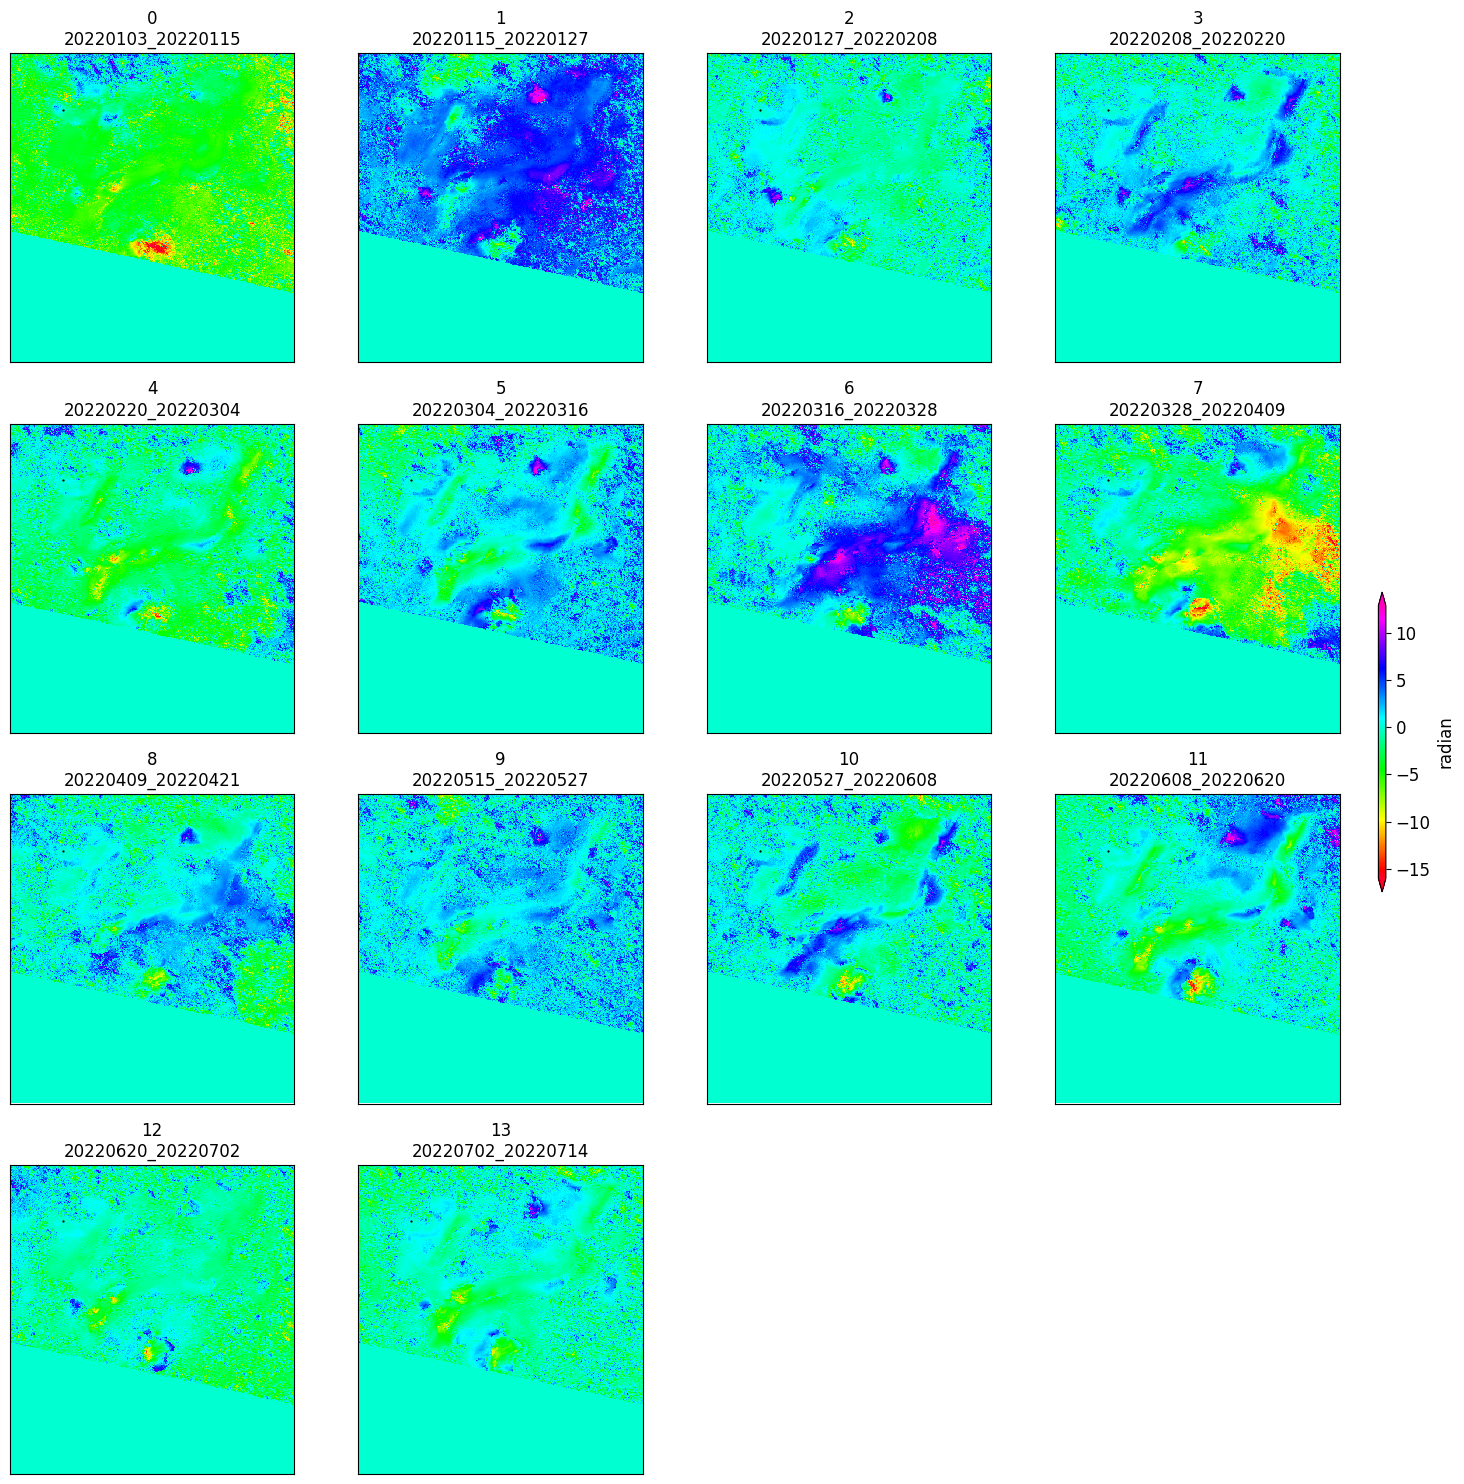

In [19]:
%matplotlib inline
scp_args = f"{mint_path}/inputs/ifgramStack.h5 --dpi 150 --figsize 15 15 -c gist_rainbow"
view.main(scp_args.split())

### 4.1.2. Interferogram Network

read temporal/spatial baseline info from file: /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_process/inputs/ifgramStack.h5
open ifgramStack file: ifgramStack.h5
['coherenceSpatialAvg.txt'] exists and is newer than ['/home/jovyan/Labs/Thesis/hyp3_look_10x2_23_process/inputs/ifgramStack.h5', 'waterMask.h5'] --> skip.
coherenceSpatialAvg.txt already exists, read it directly
number of acquisitions: 16
number of interferograms: 14
shift all perp baseline by -2.6709413528442383 to zero mean for plotting
--------------------------------------------------
number of interferograms marked as drop: 0
number of interferograms marked as keep: 14
number of acquisitions marked as drop: 0
max perpendicular baseline: 118.55 m
max temporal      baseline: 12.0 days
showing coherence
data range: [0.3535, 0.4322]
display range: (0.2, 1.0)
showing ...


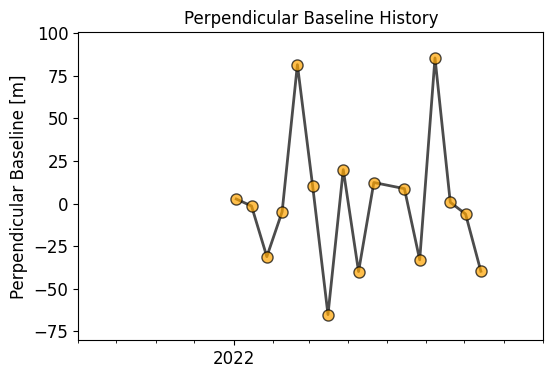

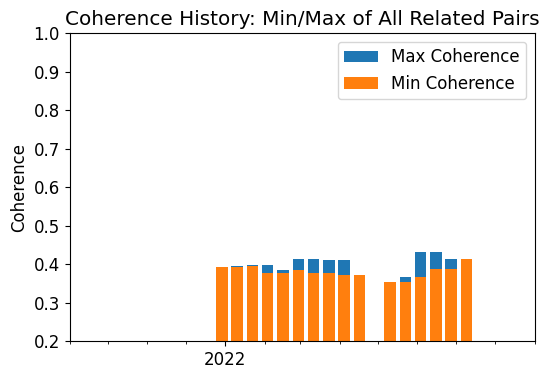

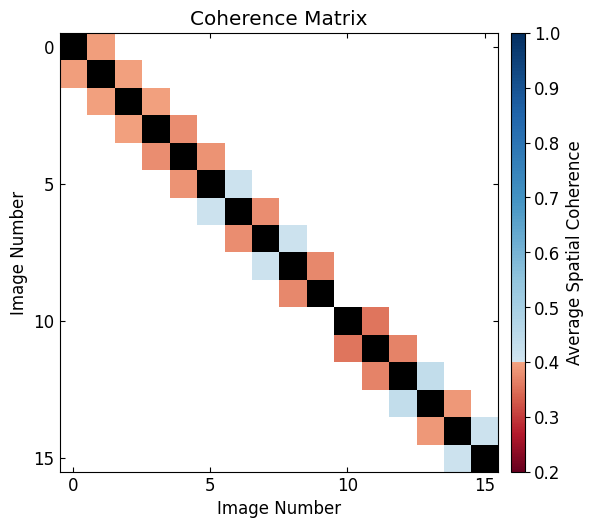

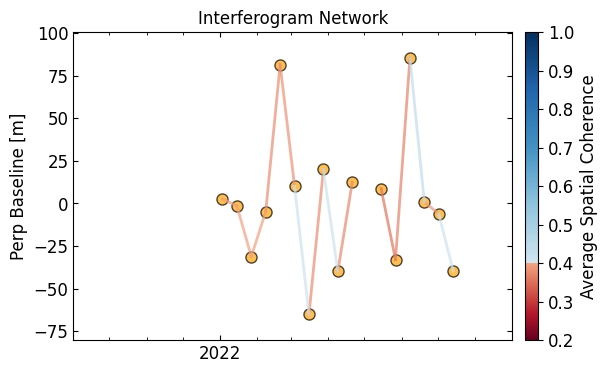

In [22]:
with asfn.work_dir(mint_path):
    plot_network.main([f'{inputs_path}/ifgramStack.h5'])
    plots = ['bperpHistory.pdf', 'coherenceHistory.pdf', 'coherenceMatrix.pdf', 'network.pdf']
    for p in plots:
        if (mint_path/p).exists():
            (mint_path/p).rename(f'{plot_path}/{p}')

### 4.1.3. Velocity

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is velocity file: /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_process/velocity.h5 in float32 format
file size in y/x: (531, 488)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 488, 531)
subset coverage in y/x: (0, 0, 488, 531)
data   coverage in lat/lon: (115.43451336302431, -2.1227793599265268, 115.61057392845626, -2.3143534587879353)
subset coverage in lat/lon: (115.43451336302431, -2.1227793599265268, 115.61057392845626, -2.3143534587879353)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
read mask from file: maskTempCoh.h5
reading data ...
masking data
masking pixels with NO_DATA_VALUE of 0.0
data    range: [-88.27922, 91.666725] cm/year
display range: [-88.27922, 91.666725] cm/year
display data in tr

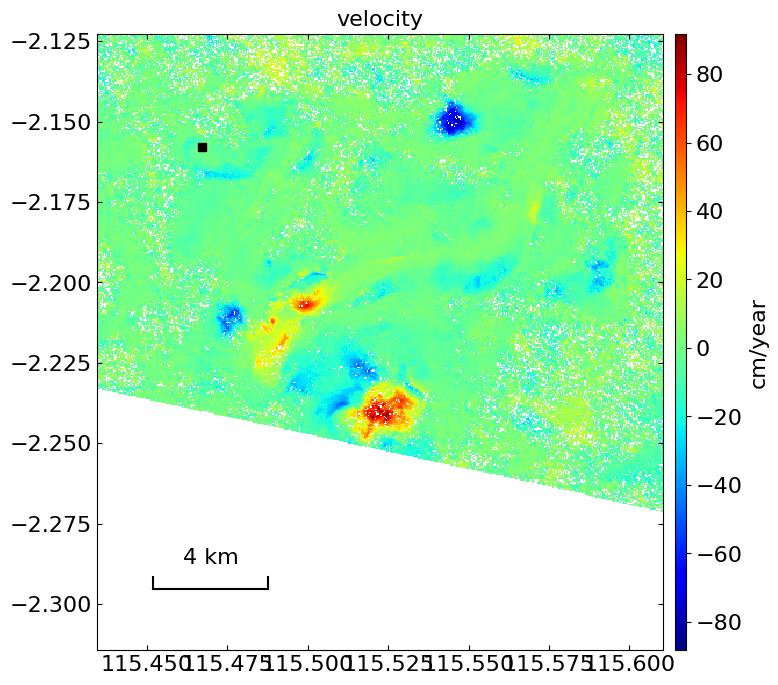

In [23]:
scp_args = f'{mint_path}/velocity.h5 velocity --dpi 600 --figsize 12 8 --outfile {plot_path}/velocity.png'
view.main(scp_args.split())

### 4.1.4 Velocity Error

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is velocity file: /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_process/velocity.h5 in float32 format
file size in y/x: (531, 488)
input dataset: "['velocityStd']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocityStd']
data   coverage in y/x: (0, 0, 488, 531)
subset coverage in y/x: (0, 0, 488, 531)
data   coverage in lat/lon: (115.43451336302431, -2.1227793599265268, 115.61057392845626, -2.3143534587879353)
subset coverage in lat/lon: (115.43451336302431, -2.1227793599265268, 115.61057392845626, -2.3143534587879353)
------------------------------------------------------------------------
colormap: RdYlGn_r
figure title: velocityStd
read mask from file: maskTempCoh.h5
reading data ...
masking data
masking pixels with NO_DATA_VALUE of 0.0
data    range: [0.0813082, 6.8281865] cm/year
display range: [0.0, 1.0] cm/year
display data in 

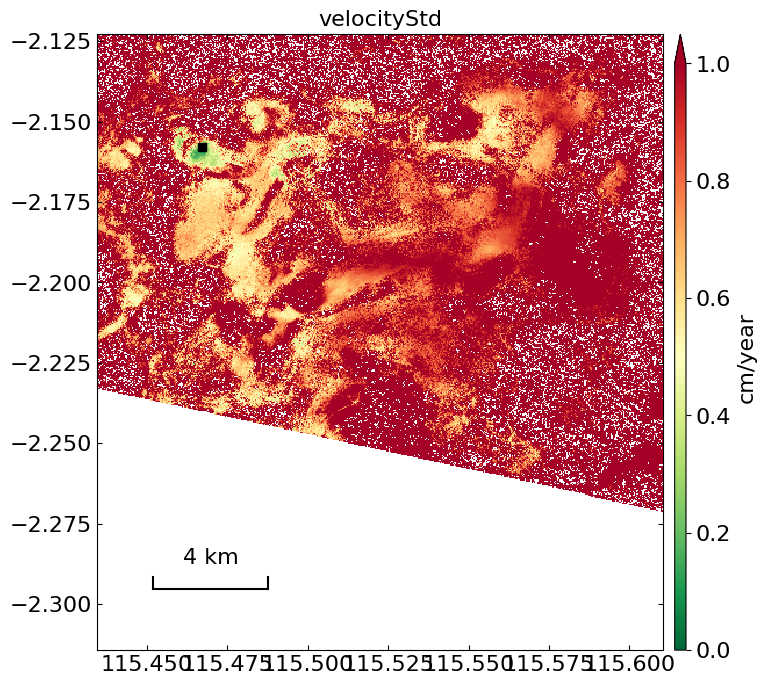

In [24]:
%matplotlib inline
scp_args = f'{mint_path}/velocity.h5 velocityStd -v 0 1 --dpi 600 --figsize 8 8 -c RdYlGn_r --outfile {plot_path}/velocity_err.png'
view.main(scp_args.split())

**Running the "reference_step" adds additional attributes "REF_X, REF_Y" and "REF_LON, REF_LAT" to the `ifgramStack.h5` file. To see the attributes of the file run `info.py`**

<div class="alert alert-info">
<b>Note :</b> 
Negative values indicates that target is moving away from the radar (i.e., Subsidence in case of vertical deformation).
Positive values indicates that target is moving towards the radar (i.e., uplift in case of vertical deformation). 
</div>

## 3.14 Plot the unwrapped inverted timeseries

**Create directories in which to store output we will create in upcoming steps**

In [25]:
geotiff_path = mint_path/'GeoTiffs'
geotiff_path.mkdir(exist_ok=True)

disp_path = geotiff_path/'displacement_maps'
disp_path.mkdir(exist_ok=True)

wrapped_path = disp_path/"wrapped"
wrapped_path.mkdir(exist_ok=True)

unwrapped_path = disp_path/"unwrapped"
unwrapped_path.mkdir(exist_ok=True)

demErr = 'timeseries_ERA5_ramp_demErr.h5'
ts_demErr = mint_path/f'{demErr}'

**Plot the unwrapped inverted time series steps (n, n+1, n+2, etc...)**

- save a png

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is timeseries file: /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_process/timeseries_ERA5_ramp_demErr.h5 in float32 format
file size in y/x: (531, 488)
num of datasets in file timeseries_ERA5_ramp_demErr.h5: 16
datasets to exclude (0):
[]
datasets to display (16):
['timeseries-20220103', 'timeseries-20220115', 'timeseries-20220127', 'timeseries-20220208', 'timeseries-20220220', 'timeseries-20220304', 'timeseries-20220316', 'timeseries-20220328', 'timeseries-20220409', 'timeseries-20220421', 'timeseries-20220515', 'timeseries-20220527', 'timeseries-20220608', 'timeseries-20220620', 'timeseries-20220702', 'timeseries-20220714']
data   coverage in y/x: (0, 0, 488, 531)
subset coverage in y/x: (0, 0, 488, 531)
data   coverage in lat/lon: (115.43451336302431, -2.1227793599265268, 115.61057392845626, -2.3143534587879353)
subset coverage in lat/lon: (115.43451336302431, -2.1227793599265268, 115.61057392845626, -2.3143534587879353)
-

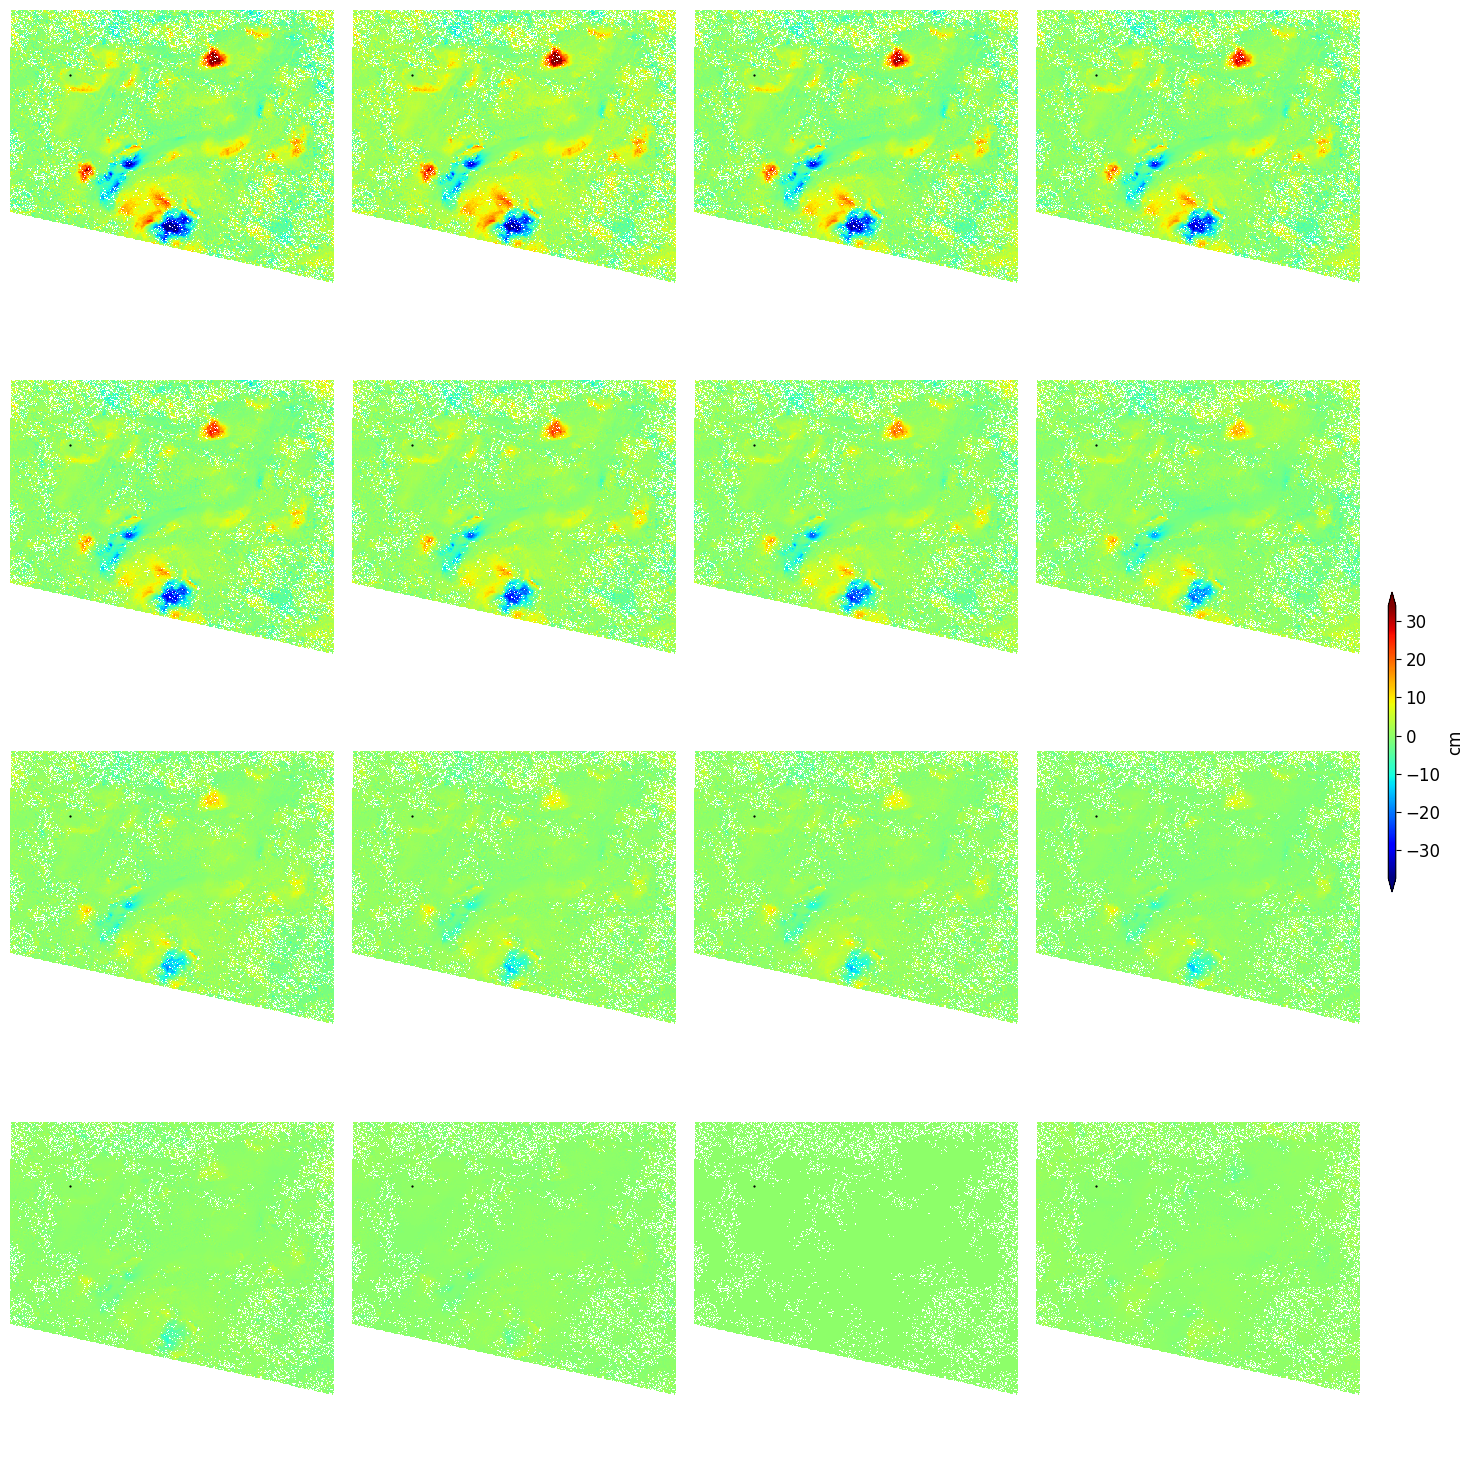

In [26]:
scp_args = f'{ts_demErr} --notitle --notick --noaxis --dpi 300 --figsize 15 15 --outfile {unwrapped_path}/unwrapped_inverted_ts.png'
view.main(scp_args.split())

# 4. Error analysis (signal vs noise)

Uncertainty of the ground displacement products derived from InSAR time-series, depends on the quality of the inversion of the stack of interferograms and the accuracy in separating the ground displacement from other components of the InSAR data. Therefore the definition of signal vs noise is different at the two main steps in MintPy:  

1) During the inversion: 
    At this step all systematic components of the interferometric phase (e.g., ground displacement, propagation delay, geometrical residuals caused by DEM or platform's orbit inaccuracy) are considered signal, while the interferometric phase decorrelation, phase unwrapping error and phase inconsistency are considered noise. 
    
2) After inversion: the ground displacement component of the time-serieses is signal, and everything else (including the propagation delay and geometrical residuals) are considered noise

Therefore we first discuss the possible sources of error during the inversion and the existing ways in MintPy to evaluate the quality of inversion and to improve the uncertainty of the inversion. Afterwards we explain the different components of the time-series and the different processing steps in MintPy to separate them from ground displacement signal.  


## 4.1. Quality of the inversion

The main sources of noise during the time-series inversion includes decorrelation, phase unwrapping error and the inconsistency of triplets of interferofgrams. Here we mainly focus on the decorrelation and unwrapping errors. We first show the existing quantities in MintPy to evaluate decorrelation and unwrapping errors and then discuss the existing ways in MintPy to reduce the decorrelation and unwrapping errors on the time-series inversion.

### 4.1.1. Average spatial coherence

Mintpy computes temporal average of spatial coherence of the entire stack as a potential ancillary measure to choose reliable pixels after time-series inversion.

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is coherence file: /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_process/avgSpatialCoh.h5 in float32 format
file size in y/x: (531, 488)
num of datasets in file avgSpatialCoh.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['coherence']
data   coverage in y/x: (0, 0, 488, 531)
subset coverage in y/x: (0, 0, 488, 531)
data   coverage in lat/lon: (115.43451336302431, -2.1227793599265268, 115.61057392845626, -2.3143534587879353)
subset coverage in lat/lon: (115.43451336302431, -2.1227793599265268, 115.61057392845626, -2.3143534587879353)
------------------------------------------------------------------------
colormap: viridis
figure title: avgSpatialCoh
reading data ...
masking pixels with NO_DATA_VALUE of 0.0
data    range: [0.0018316106, 0.9597166] 1
display range: [0.0, 1.0] 1
display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
plot scale bar: [0.2, 0.2, 0.1]
save figure to /home/jovyan/Lab

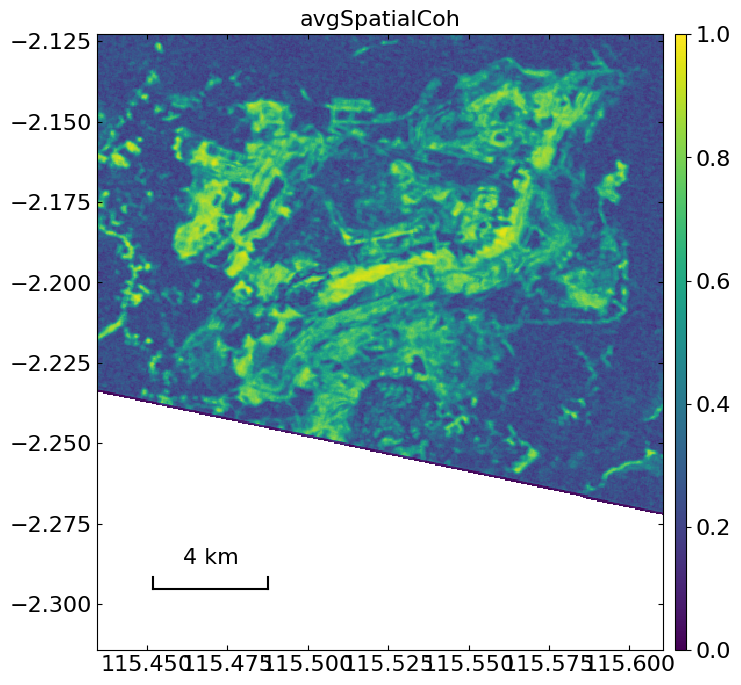

In [28]:
%matplotlib inline
scp_args = f"{mint_path}/avgSpatialCoh.h5 --dpi 600 --figsize 8 8 -c viridis --outfile {plot_path}/avg_spatial_coh.png"
view.main(scp_args.split())

Note that the plot above is the velocity error, not the velocity. The errors generally increases with distance from the reference point and can also increase for points with elevations different from the reference point if topographically correlated water vapor variations are especially strong in the area.

## 4.3. Compare InSAR time-series with GPS time-series in LOS direction



# 5. Plotting a Motion Transect 

**Select the transect to plot**

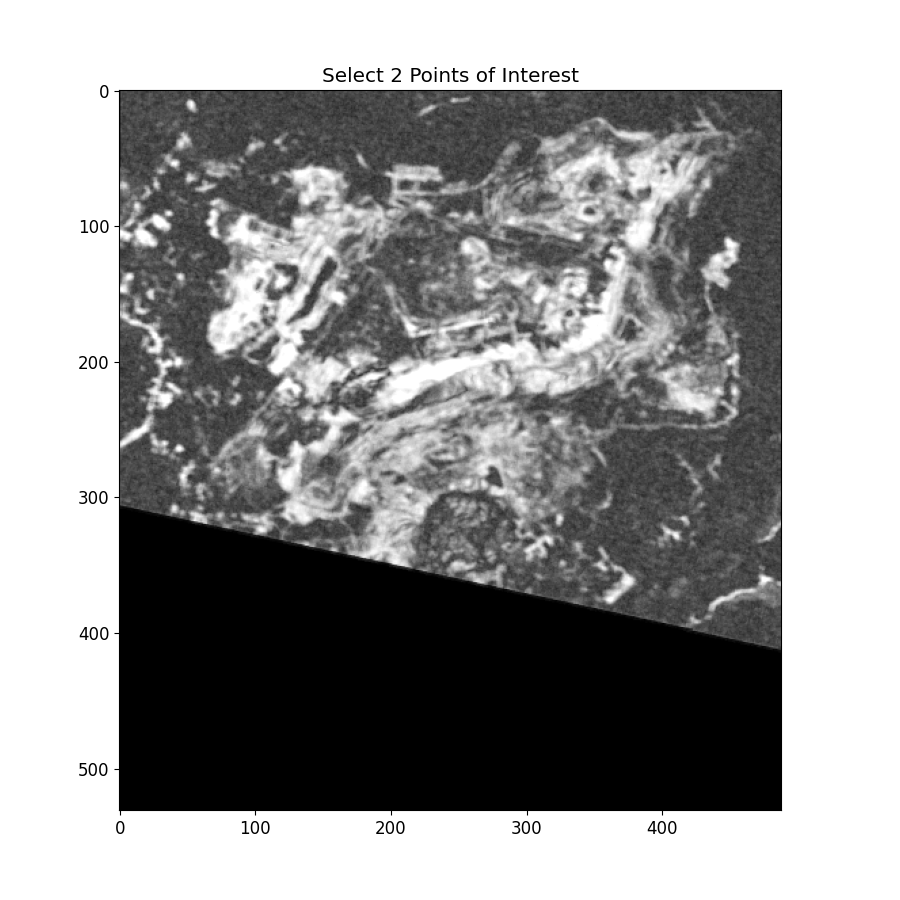

In [31]:
%matplotlib widget
image_file = f"{mint_path}/avgSpatialCoh.h5"
img = gdal.Open(image_file)
rasterstack = img.ReadAsArray()

line = asfn.LineSelector(rasterstack, 9, 9)

In [32]:
amp = list(insar_path.glob('*/*_amp_clip.tif'))[0]
amp = gdal.Open(str(amp))
geotrans = amp.GetGeoTransform()

def geolocation(x, y, geotrans):
    return [geotrans[0]+x*geotrans[1], geotrans[3]+y*geotrans[5]]

try:
    pnt_1 = geolocation(line.pnt1[0][0], line.pnt1[0][1], geotrans)
    pnt_2 = geolocation(line.pnt2[0][0], line.pnt2[0][1], geotrans)
    print(f"point 1: {pnt_1}")
    print(f"point 2: {pnt_2}")
except TypeError:
    print('TypeError')
    display(Markdown(f'<text style=color:red>This error may occur if a line was not selected.</text>'))

point 1: [115.49643805976031, -2.1877855980820615]
point 2: [115.54725841098605, -2.20720908310551]


run view.py in MintPy version 1.5.1, date 2023-01-03
input file is velocity file: /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_process/velocity.h5 in float32 format
file size in y/x: (531, 488)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 488, 531)
subset coverage in y/x: (0, 0, 488, 531)
data   coverage in lat/lon: (115.43451336302431, -2.1227793599265268, 115.61057392845626, -2.3143534587879353)
subset coverage in lat/lon: (115.43451336302431, -2.1227793599265268, 115.61057392845626, -2.3143534587879353)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
figure size : [6.89, 6.00]
read mask from file: maskTempCoh.h5
data    range: [-88.27922, 91.666725] cm/year
display range: [-88.27922, 91.666725] cm/year
figure size : [6.89, 6.00]
display data in transparency: 1.0
p

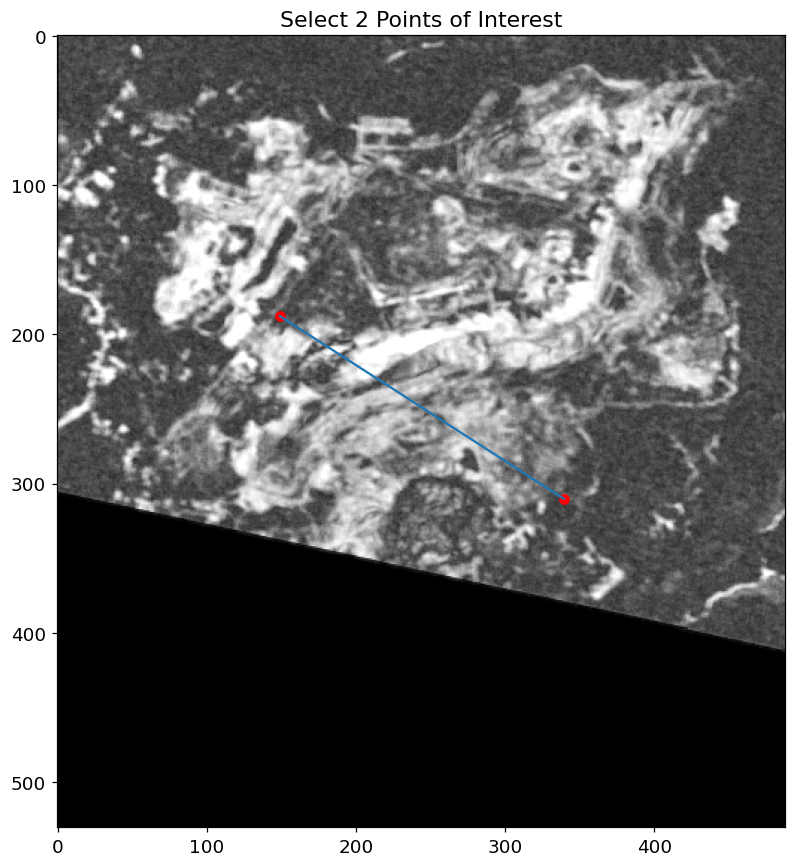

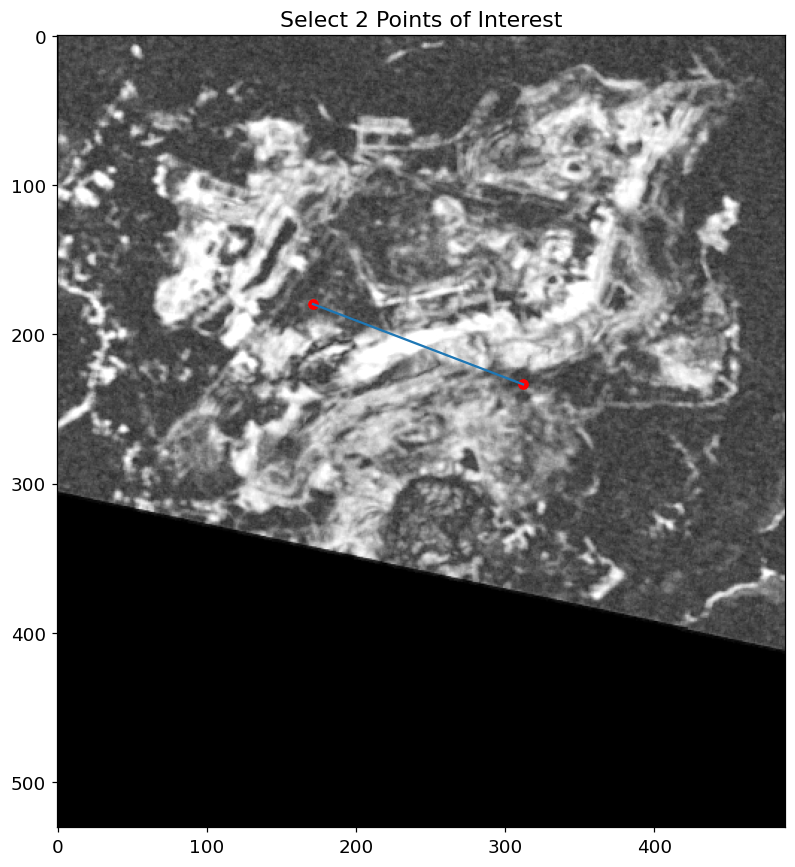

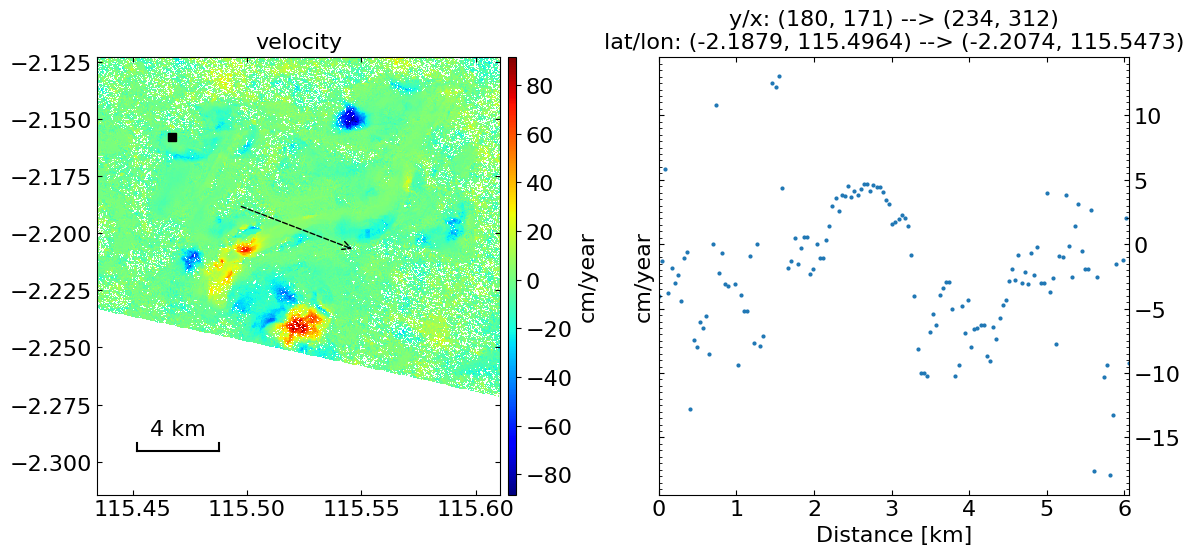

In [33]:
%matplotlib inline
scp_args = f'{mint_path}/velocity.h5 --start-lalo {pnt_1[1]} {pnt_1[0]} --end-lalo {pnt_2[1]} {pnt_2[0]} --outfile x'
with asfn.work_dir(plot_path):
    plot_transection.main(scp_args.split())

# 6. Plot the Cumulative Displacement Map and Point Displacement Time Series

- Use the `Time` bar below the Cumulative Displacement Map to view displacements for different time periods
- Click on the Cumulative Displacement Map to select points for displaying Point Displacement Time-Series

In [34]:
ts_demErr = os.path.join(mint_path, 'timeseries_ERA5_ramp_demErr.h5')
out_file = os.path.join(plot_path, 'timeseries_view.png')

tsview.py /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_process/timeseries_ERA5_ramp_demErr.h5 --lalo -2.206897 115.500869 --zero-first -c cmy
open timeseries file: timeseries_ERA5_ramp_demErr.h5
No lookup table (longitude or rangeCoord) found in files.
data   coverage in y/x: (0, 0, 488, 531)
subset coverage in y/x: (0, 0, 488, 531)
data   coverage in lat/lon: (115.43451336302431, -2.1227793599265268, 115.61057392845626, -2.3143534587879353)
subset coverage in lat/lon: (115.43451336302431, -2.1227793599265268, 115.61057392845626, -2.3143534587879353)
------------------------------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    stepDate   : []
    exp        : {}
    log        : {}
reading timeseries from file /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_process/timeseries_ERA5_ramp_demErr.h5
reference to date: 20220702
read mask from file: maskTempCoh.h5
data    range: [-50.195103, 

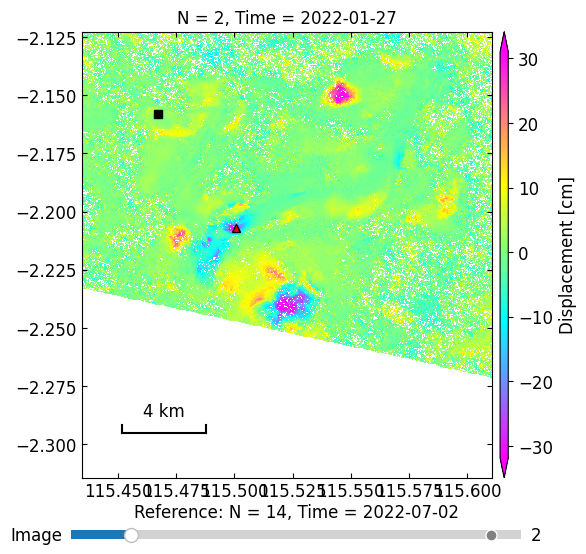

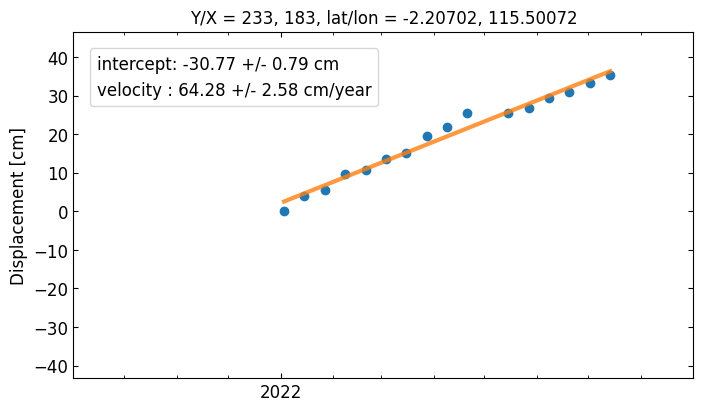

In [35]:
%matplotlib inline

'''tsview.main([str(ts_demErr),      
                    f'-d={mint_path}/inputs/geometryGeo.h5',
                    f'-o={mint_path}/displacement_ts', 
                    f'--outfile={mint_path}/displacement_ts.pdf'])'''

scp_args = f'{ts_demErr} --lalo -2.206897 115.500869 --zero-first -c cmy'
tsview.main(scp_args.split())

# 7. Generate coherence, velocity, and total displacement Geotiffs

**Create a list dates for all timesteps**

In [36]:
ifgramstack = inputs_path/"ifgramStack.h5"

with h5py.File(ifgramstack, "r") as f:
    dates = f["date"][()]
    dates = list(set([d.decode("utf-8") for insar in dates for d in insar]))
    dates.sort()
dates

['20220103',
 '20220115',
 '20220127',
 '20220208',
 '20220220',
 '20220304',
 '20220316',
 '20220328',
 '20220409',
 '20220421',
 '20220515',
 '20220527',
 '20220608',
 '20220620',
 '20220702',
 '20220714']

**Save the full displacement timeseries**

In [46]:
ds = f'{dates[0]}_{dates[-1]}'
!save_gdal.py $ts_demErr -d $ds --of GTIFF -o $geotiff_path/"save_gdal_ts_demErr.tif"

read 20220714 from file: /home/jovyan/Labs/Thesis/data_hyp3_2022_process/timeseries_ERA5_ramp_demErr.h5
read 20220103 from file: /home/jovyan/Labs/Thesis/data_hyp3_2022_process/timeseries_ERA5_ramp_demErr.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 305, 352
raster transform info: (115.3683792213817, 0.0007210507358193021, 0, -2.0619391553716047, 0, -0.0007210507358193021)
write data to raster band
set projection as: EPSG 4326
finished writing to /home/jovyan/Labs/Thesis/data_hyp3_2022_process/GeoTiffs/save_gdal_ts_demErr.tif


**Save the unwrapped displacement GeoTiffs**

In [37]:
with h5py.File(ifgramstack, 'r') as f:
    unw_pth = f.attrs['FILE_PATH']

ds_unw = rasterio.open(unw_pth, 'r', driver='GTiff')

for i, d in enumerate(tqdm(dates)):
    date_range = f'{dates[0]}_{dates[i]}'
    cmd = f'view.py {ts_demErr} {date_range} --notitle --notick --noaxis'
    data, _, _ = mintpy.view.prep_slice(cmd)
    data = data / 100 # cm -> meters
        

    with rasterio.open(f'{unwrapped_path}/{date_range}_{ts_demErr.stem}_unwrapped.tif', 'w', driver='GTiff',
                  height = data.shape[0], width = data.shape[1],
                  count=1, dtype=str(data.dtype),
                  crs=ds_unw.read_crs(),
                  transform=ds_unw.transform,
                  nodata=np.nan) as ds:
        
        ds.write(data.astype(rasterio.float32), 1)

  0%|          | 0/16 [00:00<?, ?it/s]

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is timeseries file: /home/jovyan/Labs/Thesis/hyp3_look_10x2_23_process/timeseries_ERA5_ramp_demErr.h5 in float32 format
file size in y/x: (531, 488)
input dataset: "['20220103_20220103']"
num of datasets in file timeseries_ERA5_ramp_demErr.h5: 16
datasets to exclude (0):
[]
datasets to display (1):
['timeseries-20220103']
input reference date: timeseries-20220103
data   coverage in y/x: (0, 0, 488, 531)
subset coverage in y/x: (0, 0, 488, 531)
data   coverage in lat/lon: (115.43451336302431, -2.1227793599265268, 115.61057392845626, -2.3143534587879353)
subset coverage in lat/lon: (115.43451336302431, -2.1227793599265268, 115.61057392845626, -2.3143534587879353)
------------------------------------------------------------------------
colormap: jet
figure title: timeseries-20220103_timeseries-20220103_ERA5_ramp_demErr
figure size : [6.89, 6.00]
read mask from file: maskTempCoh.h5
data    range: [0.0, 0.0] cm
display range: [

AttributeError: 'str' object has no attribute 'stem'

**Write a function to add a color ramp to single band GeoTiff**

In [48]:
def colorize_wrapped_insar(tif_path: Union[str, Path]):
    ds = gdal.Open(str(tif_path), 1)
    band = ds.GetRasterBand(1)

    # create color table
    colors = gdal.ColorTable()
    
    colors.CreateColorRamp(0, (255, 255, 0),  64, (255, 0, 0))
    colors.CreateColorRamp(64, (0, 255, 0),   128, (255, 255, 0))
    colors.CreateColorRamp(128, (0, 255, 255), 192, (0, 255, 0))
    colors.CreateColorRamp(192, (0, 0, 255),   255, (0, 255, 255))

    # set color table and color interpretation
    band.SetRasterColorTable(colors)
    band.SetRasterColorInterpretation(gdal.GCI_PaletteIndex)

    # close and save file
    del band, ds

**Collect paths to unwrapped displacement maps**

In [49]:
unwrapped_paths = list(unwrapped_path.rglob('*_unwrapped.tif'))
unwrapped_paths

[]

**Generate the wrapped interferogram GeoTiffs**

- Please note that the wrapped range used below is currently under review and may not yet correctly correspond to the Sentinel-1 wavelength 

In [50]:
sentinel_c_band_lambda = 5.5465763

for unw_path in tqdm(unwrapped_paths):
    date_range_regex = '(?<=/unwrapped/)\d{8}_\d{8}'
    date_range = re.search(date_range_regex, str(unw_path)).group(0)
    
    with rxr.open_rasterio(unw_path, masked=True).squeeze() as ds:
        # convert unwrapped raster to radians
        with xr.set_options(keep_attrs=True):
            unw_rad = (ds * -4 * np.pi) / sentinel_c_band_lambda
          
    # I don't know what it means to convert meters to radians
    # since we did that to the unw data, let's try doing the same to the wrapped range
    wrap_range = [
        (-2.8 * -4 * np.pi) / (sentinel_c_band_lambda * 100),
        (2.8 * -4 * np.pi) / (sentinel_c_band_lambda * 100)
    ]
       
    # wrap the interferogram
    with xr.set_options(keep_attrs=True):
        wrap = mintpy.utils.utils0.wrap(unw_rad, wrap_range=wrap_range)
        
    # collect crs and transform
    with rasterio.open(unw_path, 'r', driver='GTiff') as ds:
        unw_crs = ds.read_crs()
        unw_transform = ds.transform
    
    # Save wrapped interferogram as a GeoTiff
    wrp_path = wrapped_path/f'{date_range}_{ts_demErr.stem}_wrapped_unscaled.tif'
    with rasterio.open(wrp_path, 'w', driver='GTiff',
                      height = wrap.shape[0], width = wrap.shape[1],
                      count=1, dtype=str(wrap.dtype),
                      crs=unw_crs,
                      transform=unw_transform,
                      nodata=np.nan) as ds:
        ds.write(wrap.astype(rasterio.float32), 1)
        
    # scale wrapped interferogram (0 to 255)
    scaled_path = wrapped_path/f'{wrp_path.stem.split("_unscaled")[0]}_scaled.tif'
    !gdal_translate -of GTiff -scale -ot BYTE $wrp_path $scaled_path
    wrp_path.unlink()
    
    # add color ramp
    colorize_wrapped_insar(scaled_path)
    
    # convert to 3-band rgb
    three_band_path = wrapped_path/f'{scaled_path.stem.split("_scaled")[0]}.tif'
    !gdal_translate -of GTiff -expand rgb $scaled_path $three_band_path
    scaled_path.unlink()

0it [00:00, ?it/s]

**Save the temporal coherence geotiff**

In [51]:
!save_gdal.py $mint_path/temporalCoherence.h5 --of GTIFF -o $geotiff_path/TemporalCoherence.tif

read data from file: /home/jovyan/Labs/Thesis/data_hyp3_2022_process/temporalCoherence.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 305, 352
raster transform info: (115.3683792213817, 0.0007210507358193021, 0, -2.0619391553716047, 0, -0.0007210507358193021)
write data to raster band
set projection as: EPSG 4326
finished writing to /home/jovyan/Labs/Thesis/data_hyp3_2022_process/GeoTiffs/TemporalCoherence.tif


**Save the average spatial coherence geotiff**

In [52]:
!save_gdal.py $mint_path/avgSpatialCoh.h5 --of GTIFF -o $geotiff_path/avgSpatialCoh.tif

read data from file: /home/jovyan/Labs/Thesis/data_hyp3_2022_process/avgSpatialCoh.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 305, 352
raster transform info: (115.3683792213817, 0.0007210507358193021, 0, -2.0619391553716047, 0, -0.0007210507358193021)
write data to raster band
set projection as: EPSG 4326
finished writing to /home/jovyan/Labs/Thesis/data_hyp3_2022_process/GeoTiffs/avgSpatialCoh.tif


**Save the velocity geotiff**

In [53]:
velocity = f'{mint_path}/velocity.h5'
!save_gdal.py $velocity --of GTIFF -o $geotiff_path/velocity.tif

read data from file: /home/jovyan/Labs/Thesis/data_hyp3_2022_process/velocity.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 305, 352
raster transform info: (115.3683792213817, 0.0007210507358193021, 0, -2.0619391553716047, 0, -0.0007210507358193021)
write data to raster band
set projection as: EPSG 4326
finished writing to /home/jovyan/Labs/Thesis/data_hyp3_2022_process/GeoTiffs/velocity.tif


**Save the time-series displacement to shapefile**

In [58]:

!save_qgis.py -g $mint_path/inputs/geometryGeo.h5 -o $mint_path/ts_displacement.shp $ts_demErr

gather auxliary data files
TimeSeries  : /home/jovyan/Labs/Thesis/data_hyp3_2022_process/timeseries_ERA5_ramp_demErr.h5
Velocity    : /home/jovyan/Labs/Thesis/data_hyp3_2022_process/velocity.h5
Coherence   : /home/jovyan/Labs/Thesis/data_hyp3_2022_process/temporalCoherence.h5
Mask        : /home/jovyan/Labs/Thesis/data_hyp3_2022_process/maskTempCoh.h5
Geometry    : /home/jovyan/Labs/Thesis/data_hyp3_2022_process/inputs/geometryGeo.h5
output shape file: /home/jovyan/Labs/Thesis/data_hyp3_2022_process/ts_displacement.shp
number of points with time-series: 85691
[==================================================] 85692/85691   12s /     0s 
finished writing to file: /home/jovyan/Labs/Thesis/data_hyp3_2022_process/ts_displacement.shp


# Reference material

- Mintpy reference: *Yunjun, Z., H. Fattahi, F. Amelung (2019), Small baseline InSAR time series analysis: unwrapping error correction and noise reduction, preprint doi:[10.31223/osf.io/9sz6m](https://eartharxiv.org/9sz6m/).*

- University of Miami online time-series viewer: https://insarmaps.miami.edu/

- Mintpy Github repository: https://github.com/insarlab/MintPy

*MintPy_Time_Series_From_Prepared_Data_Stack.ipynb - Version 0.3.0 - January 2023*

*Version Changes*

- *store CDS credentials in `~/.cdsapirc` instead of in pyaps3 config*
- *update pyaps3 config with CDS credentials in the notebook*
- *add config option to use a local dask cluster for multithreading*
    - *interferogram inversion*
    - *dem error correction*

## Additional Visualization

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is velocity file: /home/jovyan/Labs/Thesis/data_hyp3_2022_process/velocity.h5 in float32 format
file size in y/x: (305, 352)
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (5):
['velocity', 'velocityStd', 'intercept', 'interceptStd', 'residue']
data   coverage in y/x: (0, 0, 352, 305)
subset coverage in y/x: (0, 0, 352, 305)
data   coverage in lat/lon: (115.3683792213817, -2.0619391553716047, 115.6221890803901, -2.2818596297964917)
subset coverage in lat/lon: (115.3683792213817, -2.0619391553716047, 115.6221890803901, -2.2818596297964917)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
figure size : [15.00, 8.00]
dataset number: 5
row     number: 2
column  number: 3
figure  number: 1
read mask from file: maskTempCoh.h5
----------------------------------------
Figure 1 - velocity.png
reading data as a list of 2D matrices ..

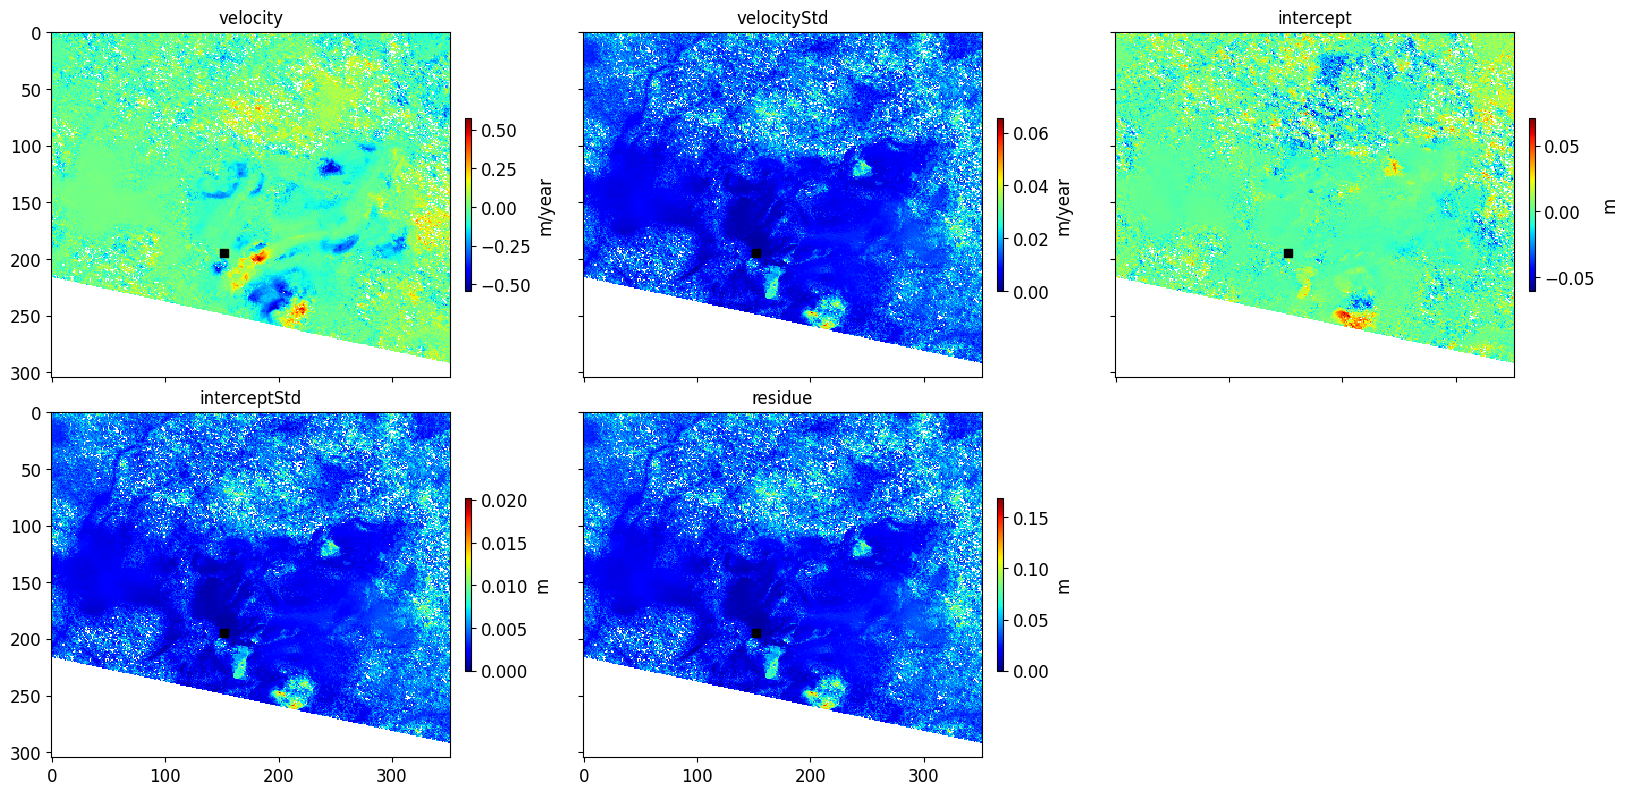

In [54]:
os.chdir(mint_path)
view.main(['velocity.h5'])